# Imports

In [1]:
import os, keras, math
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PIL import Image
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, UpSampling2D, Input, Concatenate, Add
from keras.layers import BatchNormalization, Activation, Conv2D, MaxPool2D
from keras.layers import GlobalAvgPool2D, GlobalMaxPool2D, Reshape, Multiply
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
import keras.backend as K
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

%matplotlib inline

Using TensorFlow backend.
/home/rhermoza/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# 1 Load data

In [95]:
SPLIT_VALIDATION = False

In [96]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    np.random.seed(seed)
    n_val = int(val_pct*n) if SPLIT_VALIDATION else 1
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

def split_by_idx(idxs, *a):
    mask = np.zeros(len(a[0]),dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask],o[~mask]) for o in a]

path = '/home/rhermoza/data/kaggle/statoil/'
train_data = np.load(path+'train.npy').item()

val_idxs = get_cv_idxs(train_data['x_imgs'].shape[0])
(x_val_a, x_train_a), (x_val_b, x_train_b), (y_val, y_train) = \
    split_by_idx(val_idxs, train_data['x_imgs'], train_data['x_angle'], train_data['y'])

## Preprocess

In [97]:
pp_mean = x_train_a.mean((0,1,2))
pp_std = x_train_a.std((0,1,2))

def preprocess(x): return (x-pp_mean)/pp_std
x_val_a, x_train_a = preprocess(x_val_a), preprocess(x_train_a)

In [98]:
[(x.mean(), x.std()) for x in [x_train_a, x_val_a]]

[(0.10723561, 1.0014637), (0.85459477, 0.67132771)]

## Params

In [99]:
img_size = 75
bs = 128

## Augmentation

In [100]:
x_train_a = np.vstack([x_train_a, x_train_a[:,::-1], x_train_a[:,:,::-1], x_train_a[:,::-1,::-1]])
x_train_b = np.concatenate([x_train_b]*4)
y_train = np.concatenate([y_train]*4)

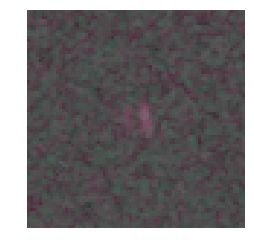

In [101]:
def plot_img(x):
    img = (x-x_train_a.min())/(x_train_a.max()-x_train_a.min())
    t = np.mean(img, -1)[...,None]
    img = np.concatenate([img, t], -1)
    plt.imshow(img)
    plt.axis('off')

plot_img(x_train_a[np.random.choice(len(y_train))])

In [102]:
def fix_dims(x): return x.astype(np.float32).reshape((-1,1))

x_val_b, x_train_b, y_val, y_train = [fix_dims(x) for x in [x_val_b, x_train_b, y_val, y_train]]
x_train = [x_train_a, x_train_b]
x_val = [x_val_a, x_val_b]
[x.shape for x in x_train], [x.shape for x in x_val]

([(6412, 75, 75, 2), (6412, 1)], [(1, 75, 75, 2), (1, 1)])

# 2. Build Model

In [10]:
def conv_layer(x, f, k=3, s=2, p='same', bn=True, d=0, reg=l2(0)):
    out = Dropout(d)(x)
    out = Conv2D(f, k, strides=s, padding=p, use_bias=False,
                 kernel_initializer='he_uniform', activation='relu',
                 kernel_regularizer=reg)(x)
    if bn: out = BatchNormalization()(out)
    return out

def res_layer(x, f, reg=l2(0)):
    se_ratio = 16
    out = conv_layer(x, f, s=1, reg=reg)
    # squeeze and excite
    out_se = GlobalAvgPool2D()(out)
    r = f // se_ratio if (f // se_ratio) > 0 else 1
    out_se = Reshape((1, f))(out_se)
    out_se = Dense(r, use_bias=False, kernel_initializer='he_uniform', activation='relu',
                   kernel_regularizer=reg, bias_regularizer=reg)(out_se)
    out_se = Dense(f, use_bias=False, activation='sigmoid',
                   kernel_regularizer=reg, bias_regularizer=reg)(out_se)
    out = Multiply()([out, out_se])
    # residual
    out = Add()([x, out])
    return out
    
def res_block(x, f, reg=l2(0)):
    l1 = conv_layer(x, f, reg=reg)
    l2 = res_layer(l1, f, reg)
    l3 = res_layer(l2, f, reg)
    return l3

def dense_layer(x, h, bn=True, act='relu', d=0, reg=l2(0)):
    out = Dropout(d)(x)
    k_init = 'he_uniform' if act == 'relu' else 'glorot_uniform'
    out = Dense(h, kernel_initializer=k_init, activation=act,
                kernel_regularizer=reg, bias_regularizer=reg)(x)
    if bn: out = BatchNormalization()(out)
    return out

def build_model(data_l=[16], conv_l=[16,32,64,128,256], cat_l=[256],
                data_d=[0], conv_d=[0.25], cat_d=[0.5],
                opt='RMSprop', reg=5e-6):
    x_a = Input((75,75,2))
    x_b = Input((1,))
    l2reg =l2(reg)

    # data layers
    x_data = BatchNormalization()(x_b)
    for h,d in zip(data_l, data_d):
        x_data = dense_layer(x_data, h, d=d, reg=l2reg)
        
    # conv_layers
    x_conv = conv_layer(x_a, 16, 5, 1, reg=l2reg)
    if len(conv_d) == 1: conv_d = conv_d*len(conv_l)
    for i,h,d in zip(range(len(conv_l)), conv_l, conv_d):
        x_conv = Dropout(d)(x_conv)
        x_conv = res_block(x_conv, h, reg=l2reg)
        
    # cat layers
    x_dense = Concatenate()([GlobalAvgPool2D()(x_conv), GlobalMaxPool2D()(x_conv)])
    out = Concatenate()([x_dense, x_data])
    for h,d in zip(cat_l, cat_d):
        out = dense_layer(out, h, d=d, reg=l2reg)
    
    out = dense_layer(out, 1, False, 'sigmoid', reg=l2reg)

    model = Model([x_a, x_b], out)
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 16)   800         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 75, 75, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 75, 75, 16)   0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# 3. Train

## 3.1 Training functions

In [12]:
class CycleLearner(keras.callbacks.Callback):
    def __init__(self, lr, nb, n_cycle, cycle_len=1, cycle_mult=1):
        super().__init__()
        self.lr = lr
        self.nb = nb*cycle_len
        self.n_cycle = n_cycle
        self.cycle_mult = cycle_mult
        self.lr_log = []
        self.losses = []
        self.iterations = []

    def on_train_begin(self, logs={}):
        self.iteration,self.epoch = 0,0
        self.cycle_iter,self.cycle_count=0,0
        self.update_lr()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_log.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)
        self.update_lr()
        if self.cycle_count == self.n_cycle:
            self.model.stop_training = True
    
    def update_lr(self):
        new_lr = self.calc_lr()
        K.set_value(self.model.optimizer.lr, new_lr)

    def calc_lr(self):
        if self.iteration<self.nb/20:
            self.cycle_iter += 1
            return self.lr/100.

        cos_out = np.cos(np.pi*(self.cycle_iter)/self.nb) + 1
        self.cycle_iter += 1
        if self.cycle_iter==self.nb:
            self.cycle_iter = 0
            self.nb *= self.cycle_mult
            self.cycle_count += 1
        return self.lr / 2 * cos_out        
        
    def plot_loss(self, skip=10):
        plt.plot(self.iterations[skip:], self.losses[skip:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_log)

def fit(model, learner, epochs=1000, verbose=1, val=SPLIT_VALIDATION):
    global log
    t0 = time()
    h = model.fit(x_train, y_train, bs, epochs=epochs,
                  validation_data=(x_val, y_val),
                  callbacks=[learner], verbose=verbose)
    if log is None:
        log = h.history
    else:
        for k in h.history:
            log[k] += h.history[k]
    if val:
        if len(log['loss']) != len(log['val_loss']):
            loss, acc = model.evaluate(x_val, y_val, verbose=0)
            log['val_loss'].append(loss)
            log['val_acc'].append(acc)
    
    if verbose == 1: print('\nDone! (%.2fs)' % (time()-t0))
        
def plot_train(skip=0, xlim=None, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(14,5))
    ax[0].plot(log['loss'][skip:], label='train')
    if SPLIT_VALIDATION: ax[0].plot(log['val_loss'][skip:], label='val')
    ax[0].set_title('loss')
    if ylim is not None: ax[0].set_ylim(np.min(log['loss']), ylim)
    if xlim is not None: ax[0].set_xlim(xlim)        
    ax[1].plot(log['acc'][skip:], label='train')
    if SPLIT_VALIDATION: ax[1].plot(log['val_acc'][skip:], label='val')
    ax[1].set_title('accuracy')
    for a in ax: a.legend()
    plt.show()

In [13]:
class LrFinder(keras.callbacks.Callback):
    def __init__(self, nb, start_lr=1e-5, end_lr=10):
        super().__init__()
        self.start_lr = start_lr
        self.lr = start_lr
        self.lr_mult = (end_lr/start_lr)**(1/nb)
        self.lr_log = []
        self.losses = []
        self.iterations = []
        
    def on_train_begin(self, logs={}):
        self.best = 1e9
        self.iteration = 0
        self.update_lr()

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_log.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)

        if math.isnan(loss) or loss>self.best*4:
            self.model.stop_training = True
        if loss<self.best:
            self.best=loss
        self.update_lr()
    
    def update_lr(self):
        new_lr = self.start_lr * (self.lr_mult**self.iteration)
        K.set_value(self.model.optimizer.lr, new_lr)
        
    def plot_loss(self):
        plt.plot(self.iterations[10:], self.losses[10:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_log)
        
    def plot(self, n_skip_start=2, xlim=None, ylim=None):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lr_log[n_skip_start:], self.losses[n_skip_start:])
        plt.xscale('log')
        if ylim is not None: plt.ylim(np.min(lr_finder.losses),ylim)
        if xlim is not None: plt.xlim(right=xlim)
        

## 3.2 Finding LR

Epoch 1/10
 512/5136 [=>............................] - ETA: 29s - loss: 0.8536 - acc: 0.4707

/home/rhermoza/anaconda3/envs/ml/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.552112). Check your callbacks.
  % delta_t_median)


3584/5136 [===================>..........] - ETA: 2s - loss: 0.8486 - acc: 0.5812

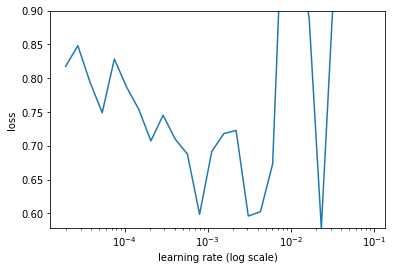

In [94]:
model = build_model()
bn = math.ceil(len(y_train)/bs)
lr_finder = LrFinder(bn)
h = model.fit(x_train, y_train, bs, epochs=10, callbacks=[lr_finder])
lr_finder.plot(ylim=0.9)

In [95]:
lr = 1e-3

## 3.22 Bayesian optimization

In [14]:
log = None
def gp_objective(params):
    K.clear_session()
    lr, lr_decay, conv_d, cat_d = params
    model = build_model(reg=lr_decay, conv_d=[conv_d], cat_d=[cat_d])
    bn = math.ceil(len(y_train)/bs)
    cycle_learner = CycleLearner(lr, bn, 4, cycle_mult=1)
    fit(model, cycle_learner, verbose=0)
    cycle_learner = CycleLearner(lr, bn, 3, cycle_mult=2)
    fit(model, cycle_learner, verbose=0)
    cycle_learner = CycleLearner(lr, bn, 2, cycle_len=4)
    fit(model, cycle_learner, verbose=0)
    return model.evaluate(x_val, y_val, verbose=0)[0]

In [ ]:
# lr, w_decay
space  = [(1e-4, 5e-2, 'log-uniform'),
          (1e-7, 1e-4, 'log-uniform'),
          (0.0,0.8),
          (0.0,0.8)]

res_gp = gp_minimize(gp_objective, space, n_random_starts=10, n_calls=100, random_state=0, verbose=True)
print('Best score=%.4f' % res_gp.fun)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 50.1302
Function value obtained: 0.3308
Current minimum: 0.3308
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 43.1072
Function value obtained: 0.3302
Current minimum: 0.3302
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 43.2705
Function value obtained: 0.2513
Current minimum: 0.2513
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 43.0423
Function value obtained: 0.5378
Current minimum: 0.2513
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 43.3614
Function value obtained: 0.8246
Current minimum: 0.2513
Iteration No: 6 started. Evalu

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 44.7339
Function value obtained: 0.2741
Current minimum: 0.2152
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 44.5934
Function value obtained: 0.2633
Current minimum: 0.2152
Iteration No: 43 started. Searching for the next optimal point.


In [17]:
best_params = {i:j for i,j in zip(['lr', 'w_decay', 'conv_d', 'cat_d'], res_gp.x)}
print('best parameters:')
print(best_params)

best parameters:
{'lr': 0.023137097728452235, 'w_decay': 9.9999999999999995e-08, 'conv_d': 0.62795539944127421, 'cat_d': 0.62657845998036055}


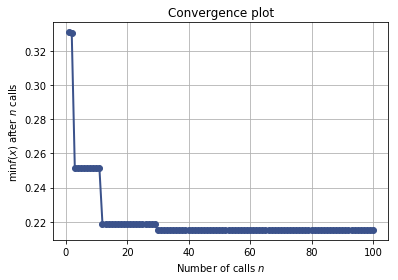

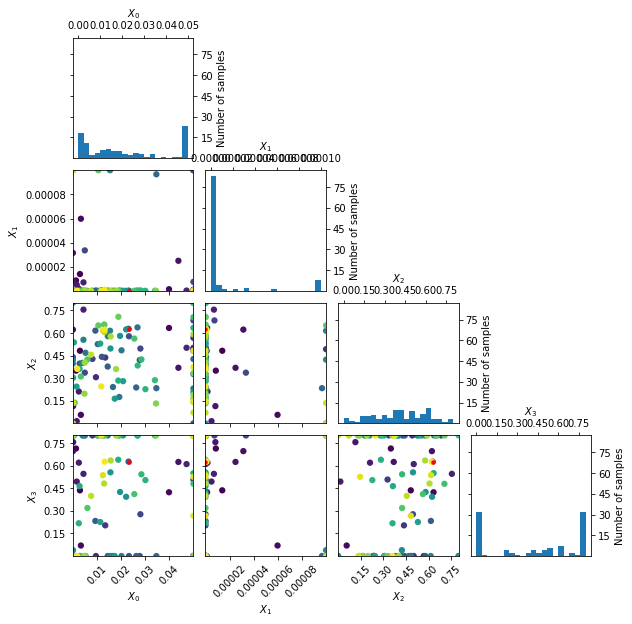

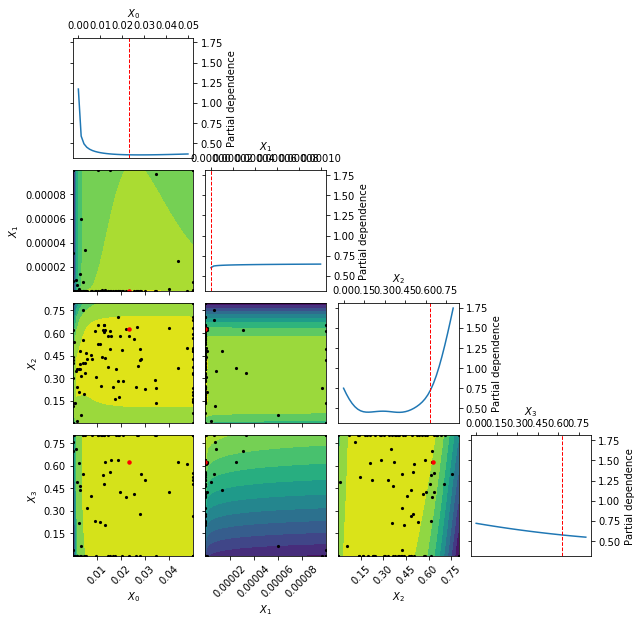

In [19]:
plot_convergence(res_gp)
plot_evaluations(res_gp)
plot_objective(res_gp);

## 3.3 TRAIN!

In [103]:
# best_params = {'lr': 0.023137097728452235, 'w_decay': 9.9999999999999995e-08, 'conv_d': 0.62795539944127421, 'cat_d': 0.62657845998036055}
best_params

{'cat_d': 0.62657845998036055,
 'conv_d': 0.62795539944127421,
 'lr': 0.023137097728452235,
 'w_decay': 9.9999999999999995e-08}

In [104]:
def eval_model(val=SPLIT_VALIDATION):
    n = len(y_train)//4
    result_train = model.evaluate([x[:n] for x in x_train], y_train[:n], bs)
    print(f'Train -> loss: %.6f, acc : %.4f' % (result_train[0], result_train[1]))
    if val:
        result_val = model.evaluate(x_val, y_val, bs)
        print(f'Val   -> loss: %.6f, acc : %.4f' % (result_val[0], result_val[1]))

In [105]:
K.clear_session()
model = build_model(reg=best_params['w_decay'], conv_d=[best_params['conv_d']], cat_d=[best_params['cat_d']])
bn = math.ceil(len(y_train)/bs)
cycle_learner = CycleLearner(best_params['lr'], bn, 4, cycle_mult=1)
log = None

fit(model, cycle_learner)
eval_model()

Train on 6412 samples, validate on 1 samples
Epoch 1/1000
6412/6412 [==============================] - 3s 533us/step - loss: 0.6291 - acc: 0.6733 - val_loss: 16.1189 - val_acc: 0.0000e+00
Epoch 2/1000
6412/6412 [==============================] - 2s 360us/step - loss: 0.5826 - acc: 0.7048 - val_loss: 16.1194 - val_acc: 0.0000e+00
Epoch 3/1000
6412/6412 [==============================] - 2s 360us/step - loss: 0.6239 - acc: 0.6433 - val_loss: 2.9004 - val_acc: 0.0000e+00
Epoch 4/1000
6400/6412 [============================>.] - ETA: 0s - loss: 0.6013 - acc: 0.6744
Done! (14.57s)
1603/1603 [==============================] - 0s 132us/step
Train -> loss: 1.999743, acc : 0.6251


In [106]:
cycle_learner = CycleLearner(best_params['lr'], bn, 3,  cycle_mult=2)
fit(model, cycle_learner)
eval_model()

Train on 6412 samples, validate on 1 samples
Epoch 1/1000
6412/6412 [==============================] - 2s 361us/step - loss: 0.5316 - acc: 0.7318 - val_loss: 0.6107 - val_acc: 1.0000
Epoch 2/1000
6412/6412 [==============================] - 2s 360us/step - loss: 0.4781 - acc: 0.7633 - val_loss: 1.6053 - val_acc: 0.0000e+00
Epoch 3/1000
6412/6412 [==============================] - 2s 361us/step - loss: 0.3689 - acc: 0.8303 - val_loss: 0.3757 - val_acc: 1.0000
Epoch 4/1000
6412/6412 [==============================] - 2s 362us/step - loss: 0.3834 - acc: 0.8203 - val_loss: 3.1773 - val_acc: 0.0000e+00
Epoch 5/1000
6412/6412 [==============================] - 2s 362us/step - loss: 0.3246 - acc: 0.8498 - val_loss: 6.4435 - val_acc: 0.0000e+00
Epoch 6/1000
6412/6412 [==============================] - 2s 362us/step - loss: 0.2797 - acc: 0.8821 - val_loss: 0.0120 - val_acc: 1.0000
Epoch 7/1000
6400/6412 [============================>.] - ETA: 0s - loss: 0.2462 - acc: 0.8964
Done! (16.21s)
1603/

In [107]:
cycle_learner = CycleLearner(best_params['lr'], bn, 4, cycle_len=4)
fit(model, cycle_learner)
eval_model()

Train on 6412 samples, validate on 1 samples
Epoch 1/1000
6412/6412 [==============================] - 2s 362us/step - loss: 0.3047 - acc: 0.8638 - val_loss: 0.0314 - val_acc: 1.0000
Epoch 2/1000
6412/6412 [==============================] - 2s 363us/step - loss: 0.2823 - acc: 0.8784 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 3/1000
6412/6412 [==============================] - 2s 363us/step - loss: 0.2508 - acc: 0.8980 - val_loss: 0.8492 - val_acc: 0.0000e+00
Epoch 4/1000
6412/6412 [==============================] - 2s 362us/step - loss: 0.2292 - acc: 0.9111 - val_loss: 0.0419 - val_acc: 1.0000
Epoch 5/1000
6412/6412 [==============================] - 2s 363us/step - loss: 0.2782 - acc: 0.8815 - val_loss: 1.4906 - val_acc: 0.0000e+00
Epoch 6/1000
6412/6412 [==============================] - 2s 363us/step - loss: 0.2568 - acc: 0.8893 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 7/1000
6412/6412 [==============================] - 2s 362us/step - loss: 0.2198 - acc: 0.9117 - val_loss: 0.0266

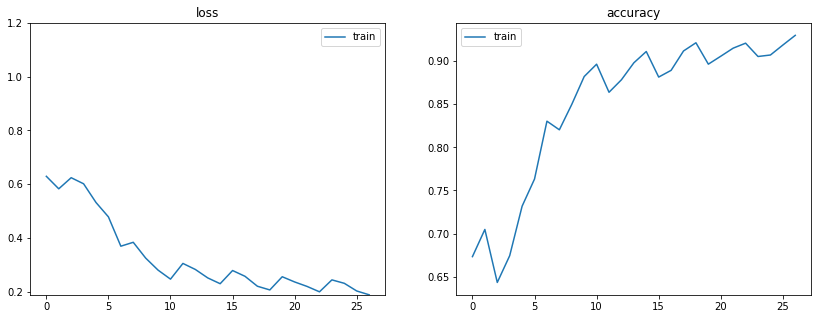

In [108]:
plot_train(ylim=1.2)

In [109]:
eval_model()

1603/1603 [==============================] - 0s 118us/step
Train -> loss: 0.157419, acc : 0.9395


## 3.4 Save weights

In [88]:
model.load_weights('data/model.h5')

In [110]:
model.save_weights('data/model.h5')

In [111]:
!ls -lh data

total 8.4M
-rw-rw-r-- 1 rhermoza rhermoza 8.4M Dec 17 21:21 model.h5


# 4. Run on test set

In [112]:
# load test data
test_data = np.load(path+'test.npy').item()
x_test_a = preprocess(test_data['x_imgs'])
x_test = [x_test_a, test_data['x_angle']]

In [113]:
y_ = model.predict(x_test, bs, 1)

8424/8424 [==============================] - 1s 155us/step


In [114]:
import pandas as pd

df = pd.DataFrame({'id': test_data['ids'], 'is_iceberg':y_.flatten()})
df.to_csv('data/submission.csv', index=False)

from IPython.display import FileLink, display
display(df.head())
FileLink('data/submission.csv')

,id,is_iceberg
0,5941774d,0.038290
1,4023181e,0.106098
2,b20200e4,0.107162
3,e7f018bb,0.998000
4,4371c8c3,0.070532


/home/rhermoza/github/kaggle-statoil/data/submission.csv